In [1]:
from sklearn.utils import shuffle

%run data.py
%run images_proc.py
%run cnn.py

In [2]:
x_data, y_data = load_data('../../datasets/expanded1.p')
x_test_data, y_test_data = load_data('../../datasets/expanded_test.p')
#x_data = preprocess_images(x_data)
#x_test_data = preprocess_images(x_test_data)

x_train, x_validation, y_train, y_validation = split_data(x_data, y_data)

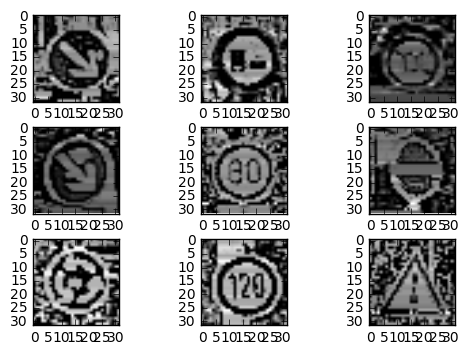

In [3]:
_ = plot_images(x_train[0:9]).show()

In [4]:
EPOCHS = 500
BATCH_SIZE = 128

filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 32

fc_size = 128

img_size = x_train[0].shape[0]
img_size_flat = x_train[0].shape[1] * x_train[0].shape[0]
img_shape = (img_size, img_size)

num_channels = x_train[0].shape[2]
num_classes = max(y_train)+1

stddev=0.1
rate = 0.0001

In [5]:
#tf.reset_default_graph() 

keep_prob = tf.placeholder(tf.float32, (None), name='Placeholderkeepprob')
x = tf.placeholder(tf.float32, (None, img_size, img_size, num_channels), name='PlaceholderX')
y = tf.placeholder(tf.int32, (None), name='PlaceholderY')

one_hot_y = tf.one_hot(y, num_classes, name='onehoty')

layer_conv1, weights_conv1 = new_conv_layer(x, num_channels, filter_size1, num_filters1, True, name='layer1')
layer_conv2, weights_conv2 = new_conv_layer(layer_conv1, num_filters1, filter_size2, num_filters2, True, name='layer2')        

fc0 = flatten(layer_conv2)
fc1 = new_fc_layer(fc0,2048,fc_size, name='fc1')
dropout = tf.nn.dropout(fc1, keep_prob, name='dropout1')
    
logits = new_fc_layer(dropout,fc_size,num_classes, name='fc2')


Layer: [5, 5, 1, 16]
Layer: [5, 5, 16, 32]


In [6]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name='correctprediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracyoperation')

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y, name='crossentropy')
loss_operation = tf.reduce_mean(cross_entropy, name='lossoperation')

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation, name='trainingoperation')

In [7]:
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        xx, yy = (x_train,y_train)
        
        #xx, yy = balanced_subsample(x_train, y_train)
        yy = yy.astype(int)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = xx[offset:end], yy[offset:end]
            sess.run(training_operation, 
                     feed_dict={x: batch_x, y: batch_y, keep_prob:0.6})
            
        validation_accuracy = evaluate(accuracy_operation, x_validation, y_validation, x, y, keep_prob)
        print("{} Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
        
    #try:
    #    saver
    #except NameError:
    #    saver = tf.train.Saver()
    saver.save(sess, 'traffic_sign_classifier_exp.ckpt')
    print("Model saved")

Training...

1 Validation Accuracy = 0.192
2 Validation Accuracy = 0.393
3 Validation Accuracy = 0.468
4 Validation Accuracy = 0.517
5 Validation Accuracy = 0.568
6 Validation Accuracy = 0.617
7 Validation Accuracy = 0.670
8 Validation Accuracy = 0.719
9 Validation Accuracy = 0.748
10 Validation Accuracy = 0.762
11 Validation Accuracy = 0.782
12 Validation Accuracy = 0.797
13 Validation Accuracy = 0.803
14 Validation Accuracy = 0.815
15 Validation Accuracy = 0.827
16 Validation Accuracy = 0.838
17 Validation Accuracy = 0.840
18 Validation Accuracy = 0.851
19 Validation Accuracy = 0.860
20 Validation Accuracy = 0.875
21 Validation Accuracy = 0.882
22 Validation Accuracy = 0.894
23 Validation Accuracy = 0.897
24 Validation Accuracy = 0.903
25 Validation Accuracy = 0.908
26 Validation Accuracy = 0.912
27 Validation Accuracy = 0.914
28 Validation Accuracy = 0.915
29 Validation Accuracy = 0.923
30 Validation Accuracy = 0.920
31 Validation Accuracy = 0.928
32 Validation Accuracy = 0.930
33 V

In [8]:
#tf.reset_default_graph() 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('traffic_sign_classifier_exp.ckpt.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(accuracy_operation, x_test_data, y_test_data, x,y,keep_prob)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.997
